In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/11/07 16:36
# @Author  : Wang Yujia
# @File    : PT_gen_oneforall.ipynb
# @Description : calculating U&P with inferred param

# 0. What for
1. 用infer的结果来算U和P
2. 使用的params是common parameter
3. 设置threshold = K = 300
    - T < 300的padding（补零）
    - T > 300的求和到最后一个值

# 1. Preparations
## 1.1 全局设置

In [4]:
# data path
data_selected_path = "../../data/SA_PT/datawithnp_PT_selected.csv"
# data key path
data_key_path = "../../data/SA_PT/data_key_PT.csv"
# inferred params
params_opitim_oneforall_path = "../../data/SA_PT/params_opitim_oneforall.csv"

# output path
output_path_root = "../../data/SA_PT/results/"
filename_head = "PT_oneforall_"
filename_tail = ".csv"

features_GT = ['bidincrement','bidfee','retail']

import numpy as np
import csv
import pandas as pd
from visdom import Visdom
from SA_for_PT_funcs_delta_eq1 import *
from tqdm import tqdm
import json


## 1.2 data 读取
1. data_key不变
2. 并且提取成功infer的参数结果`params_all`

In [5]:
data = pd.read_csv(data_selected_path, encoding="utf-8")
params_all = pd.read_csv(params_opitim_oneforall_path, encoding="utf-8")

In [6]:
data_key = data[features_GT].copy()
data_key.drop_duplicates(inplace=True,ignore_index=True)
data_key.to_csv(data_key_path,header=True, encoding="utf-8",index=False)
data_key.shape

(605, 3)

## 1.3 functions about 'key'

In [7]:
# get key from i in 'data_key'
def get_key_from_index(i,flag="NotStr"):
    if(flag == "str"):
        key_i = list(data_key.iloc[i,:])
        key_i_str = (str(key_i[0]),str(key_i[1]),str(key_i[2]))
        return key_i_str
    else:
        key_i = data_key.iloc[i,:-1]
        return key_i

#features_GT = ['bidincrement','bidfee','retail']
def select_data_fromkey(key_i_str):
    return data[(data['bidincrement'] == key_i_str[0]) & (data['bidfee'] == key_i_str[1]) & (data['retail'] == key_i_str[2])].copy()

## 1.4 get alpha, lambda
1. 得到avg_loss最小值对应的alpha和lambda

In [8]:
params = params_all[min(params_all.avg_loss) == params_all.avg_loss]
alpha = np.float64(params.alpha)
delta = 1
labda = np.float64(params.labda)
print(f"The alpha = {alpha}, delta = 1, lambda = {labda}")
data_key['T'] = np.array((data_key.retail - data_key.bidfee) / data_key.bidincrement, dtype=int)

The alpha = -0.013581112, delta = 1, lambda = 3.312402533


# 2. U & P
## 2.1 generate

1. 对不同的auction settings做generate
2. generate过程: u-->p，然后把P存到dict里
3. U 由 `f_equi`得到
4. `P[t] = U[0]*U[1]*U[2]...*U[t]*U[t+1]`
5. `tmp[T]*U[T]`并不等于`1-sum(P[key_i])`而且后者可能是个负值
6. 对于是否设置`threshold_flag`，有不同的处理方式

In [9]:
# whether set threshold or not
threshold_flag = 1
plot_flag = 0

K = 300
col_names = ['bidincrement','bidfee','retail']
tmp = np.arange(0,K)
tmp_str = [str(x) for x in tmp]
col_names.extend(tmp_str)

P = pd.DataFrame(columns=col_names)

if(plot_flag):
    env_str = 'P_oneforall_threshold'
    viz = Visdom(env=env_str)

print("Done")

Done


7. 想对比归一化的区别：可以把第一个elif的条件改了
8. `P[i]`表示`duration=i+1`的概率，i从0开始计数

In [10]:
# solve for U & P
# data_key.shape[0]
cnt = 0
zero_padding_len = []
for i in tqdm(range(data_key.shape[0])):

    # get i_th data_key
    key_i = get_key_from_index(i)
    data_i = select_data_fromkey(key_i)
    data_i.reset_index(drop=True,inplace=True)

    # Get params
    # cnt_n_2_i = data_i['cnt_n_2'].astype(int)       # Number of occurrences of different durations
    v = float(data_i['retail'].unique())            # retail price = valuation
    d = float(data_i['bidincrement'].unique())      # bid increment
    b = float(data_i['bidfee'].unique())            # bid fee
    T_i = int((v-b)/d)                              # duration limitation

    key_i_str = get_key_from_index(i,"str")         # key for P

    # Solve for U
    U = [0] * (T_i + 1)                               # the prob. that someone offers a bid in t_th round
    U[0] = 1
    for t in range(1,T_i+1):
        U[t] = f_Equi(t, v, d, b, alpha, labda)

    # Decide whether set threshold or not
    if (threshold_flag != 1):
        K = T_i

    # Solve for P
    p = np.array([0.0]*(K))
    tmp = np.array([0.0]*(K+3))                         # tmp的大小不需要太精确
    tmp[0] = 1.0

    if(threshold_flag and ((K+1) > T_i)):               # threshold>T_i时，补零
        cnt += 1
        zero_padding_len.append(K+1-T_i)
        for t in range(0,T_i):
            tmp[t+1] = tmp[t]*U[t]                      # tmp[t]存了到(t-1)的连乘积
            p[t] = (1-U[t+1])*tmp[t+1]
        # new added: 不再补0，将p[t]的概率平均分配到后面的位置上

    elif (threshold_flag and ((K+1) == T_i)):                                   # threshold=T_i时，正常操作就好
        for t in range(0,K):
            tmp[t+1] = tmp[t]*U[t]                      # tmp[t]存了到(t-1)的连乘积
            p[t] = (1-U[t+1])*tmp[t+1]
        p[K-1] = 1-sum(p)

    elif (threshold_flag and ((K+1) < T_i)):            # threshold<T_i时，归一化
        for t in range(0,K):                            # 注意是k+1不是k
            tmp[t+1] = tmp[t]*U[t]                      # tmp[t]存了到(t-1)的连乘积
            p[t] = (1-U[t+1])*tmp[t+1]                  # Alert: 当U很大接近1，p[t]很可能为0，下面scale_sum也会=0

        # 归一化？
        scale_sum = np.sum(p)
        if(scale_sum == 0):
            print("i:",i)                 # 490
            print("key_i_str",key_i_str)  # ('0.02', '0.6', '2799.99')在小于250时P会全0！！
            print("after",p)
            print("U[0:300]",U[0:300])
        # assert scale_sum == 0, "ZERO!!!!"
        p = p/scale_sum

        # if(i==490):
        #     print("after",p)
        #     print("U[0:300]",U[0:300])

    else:
        print("K: T_i: ",K,T_i)
        print("Undecided yet. Waiting to be completed.")

    # Concat df P
    pd_tmp = pd.DataFrame(data=[[d,b,v]])
    pd_tmp = pd.concat([pd_tmp,pd.DataFrame(p).T],axis=1)
    pd_tmp.columns = col_names
    # P = P.append(pd_tmp,ignore_index=True)
    P = pd.concat([P,pd_tmp],ignore_index=True)

    # Plot
    if(plot_flag& (i%10 == 0)):
        viz.line(p,np.arange(0,p.shape[0]),win = 'P_'+str(i),env=env_str, opts= dict(title = f'P_{i}_v={v}_b={b}_d={d}'))
print("Done")
print(cnt)

100%|██████████| 605/605 [00:46<00:00, 13.09it/s]

Done
123


(array([2., 1., 4., 2., 2., 0., 1., 2., 1., 2., 0., 1., 1., 0., 2., 0., 2.,
        4., 0., 1., 0., 3., 0., 0., 2., 2., 1., 3., 0., 0., 2., 0., 0., 4.,
        0., 2., 1., 0., 1., 0., 1., 0., 2., 0., 3., 1., 1., 1., 0., 5., 2.,
        1., 2., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 3., 1., 2.,
        2., 1., 1., 0., 0., 2., 1., 0., 0., 0., 0., 3., 2., 0., 0., 2., 2.,
        0., 1., 1., 0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 0., 2., 0., 0.,
        0., 2., 4., 1., 1., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 3.]),
 array([  2.        ,   4.11382114,   6.22764228,   8.34146341,
         10.45528455,  12.56910569,  14.68292683,  16.79674797,
         18.91056911,  21.02439024,  23.13821138,  25.25203252,
         27.36585366,  29.4796748 ,  31.59349593,  33.70731707,
         35.82113821,  37.93495935,  40.04878049,  42.16260163,
         44.27642276,  46.3902439 ,  48.50406504,  50.61788618,
         52.73170732,  54.84552846,  56.95934959,  59.0731

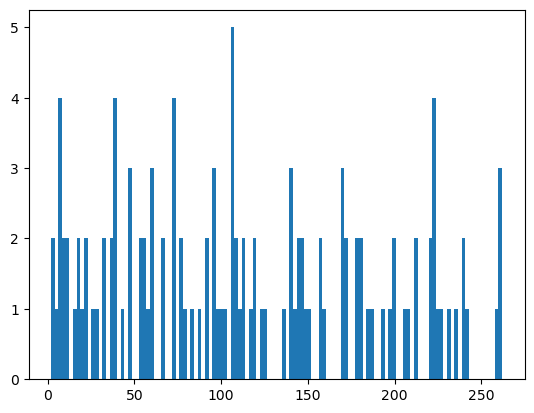

In [12]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(111)
# padding zero hist: 太多padding with zero会影响效果
ax.hist(zero_padding_len,bins=len(zero_padding_len))

## 2.3 save
1. 保存结果以及viz环境

In [114]:
# 保存整个环境
if(plot_flag):
    viz.save(envs=[env_str])

if(threshold_flag):
    K_str = str(K)
else:
    K_str = str(0)

filename_P = output_path_root+(filename_head + "P_K=" +K_str+ filename_tail)
P.to_csv(filename_P,header=True,index=False,encoding="utf-8")
print("DONE")
print(filename_P)
print(np.sum(np.sum(pd.isna(P))))

DONE
../../data/SA_PT/results/PT_oneforall_P_K=300.csv
0


In [103]:
import json
fileName_viz = "../data/vis/env_P.json"
# 保存指定的win
def saveVisdomData(win, env, fileName, mode='w'):
	'''
		模型训练完或中断时，可以先将前阶段visdom的数据保存到本地
		arg:
			win:　窗口名称
			env:　环境名称
			fileName:　保存文件路径
			mode:　文件保存格式，‘w’表示重写，‘a’表示添加在末端
	'''
    # rewrite or append
    assert mode=='w' or mode=='a'
    viz = Visdom()
    win_data = viz.get_window_data(win, env)
    pre_data = json.loads(win_data)
    x = pre_data["content"]["data"][0]["x"]  # x坐标的值
    y1 = pre_data["content"]["data"][0]["y"]  # 曲线１
    y2 = pre_data["content"]["data"][1]["y"]  # 曲线２
    assert len(x)==len(y1)==len(y2)
    with open(fileName_viz, mode) as f:
        writer = csv.writer(f)
        for i in range(len(x)):
            writer.writerow([x[i], y1[i], y2[i]])

# saveVisdomData()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 12)

# 4. 读取json并且还原viz环境

In [11]:

viz_path = "../data/vis/P.json"
with open(viz_path,"r") as f:
    pre_data=json.load(f)

tmp = pre_data['jsons'].values()
for i in range(0,len((pre_data['jsons']).keys())):
    tmpi = list(tmp)[i]
    viz.line(
        X=np.array(tmpi['content']["data"][0]["x"]),
        Y=np.array(tmpi['content']["data"][0]["y"]),
        env = "P_oneforall",
        win = tmpi['id'],
        opts= dict(title=tmpi['title']),
    )